In [1]:
%matplotlib inline

# Table of contents

* ## [Exploratory Analysis](#EDA)
    * ### [Single Variable](#single)
    * ### [Pair-wise Variables](#pair)
* ## [Model](#model)
    * ### [Null Model](#Null)
    * ### [Logistic Regression](#log)
* ## [Validation](#validation)

# Defining Our Packages and Helper Functions

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import math
import sqlite3
import ndjson
from tabulate import tabulate
import statsmodels.api as sm
import os
sns.set(style="whitegrid")

These helper functions will be used to help efficiently explore the data.

In [3]:
# Helper Functions
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)
def ex(stats, stat):
    return stats.loc[[stat]].values[0]
# Function to plot histogram of various bins
def plot_various_bins(data, label):
    figure = plt.figure(figsize=(20, 6))
    ds = data[label].describe()
    range_data = math.ceil(ex(ds, "max") - ex(ds, "min"))
    min_data = math.floor(ex(ds, "min"))
    max_data = math.ceil(ex(ds, "max"))
    n = len(data)
    h = freeman_diaconis(data[label])
    k = math.ceil(range_data / h)
    bins = [i for i in range(min_data, max_data, h)]
    axes = figure.add_subplot(1, 3, 1)
    axes.hist(data[label], bins = bins, density=True, color="DimGray")
    axes.set_ylabel("Density")
    axes.set_xlabel(label)
    axes.set_title("Density Histogram of " + label + "; Freeman Diaconis bins; " + str(k))

    k = math.ceil(2*math.pow(n,1/3))
    h = math.floor(range_data / k)
    bins = [i for i in range(min_data, max_data,h)]
    axes = figure.add_subplot(1, 3, 2)
    axes.hist(data[label], bins = bins, density=True, color="DimGray")
    axes.set_ylabel("Density")
    axes.set_xlabel(label)
    axes.set_title("Density Histogram of " + label + "; Sturges' bins: " + str(k))

    k = math.ceil(math.log(n,2.0) + 1.0)
    h = math.floor(range_data / k)
    bins = [i for i in range(min_data, max_data,h)]
    axes = figure.add_subplot(1, 3, 3)
    axes.hist(data[label], bins = bins, density=True, color="DimGray")
    axes.set_ylabel("Density")
    axes.set_xlabel(label)
    axes.set_title("Density Histogram of " + label + "; Rice bins: " + str(k))

    plt.show()
    plt.close()
    
def plot_various_bins_manual(data, label, bin1, bin2, bin3):
    figure = plt.figure(figsize=(20, 6))
    ds = data[label].describe()
    range_data = math.ceil(ex(ds, "max") - ex(ds, "min"))
    min_data = math.floor(ex(ds, "min"))
    max_data = math.ceil(ex(ds, "max"))
    axes = figure.add_subplot(1, 3, 1)
    axes.hist(data[label], bins = bin1, density=True, color="DimGray")
    axes.set_ylabel("Density")
    axes.set_xlabel(label)
    axes.set_title("Density Histogram of " + label + "; Number of bins: " + str(bin1))

    axes = figure.add_subplot(1, 3, 2)
    axes.hist(data[label], bins = bin2, density=True, color="DimGray")
    axes.set_ylabel("Density")
    axes.set_xlabel(label)
    axes.set_title("Density Histogram of " + label + "; Number of bins: " + str(bin2))

    axes = figure.add_subplot(1, 3, 3)
    axes.hist(data[label], bins = bin3, density=True, color="DimGray")
    axes.set_ylabel("Density")
    axes.set_xlabel(label)
    axes.set_title("Density Histogram of " + label + "; Number of bins: " + str(bin3))

    plt.show()
    plt.close()

# EDA - Exploratory Data Analysis <a class="anchor" id="EDA"></a>

We being our Exploratory data analysis by first loading the data.

In [4]:
## Create the sqlite3 connection to db
con = sqlite3.connect('Database/chessdb.db')

In [5]:
query = "SELECT * FROM all_games_country_selected;"
data = pd.read_sql(query,con)
data.drop("index", axis = 1, inplace = True)

In [6]:
data.dtypes

gameid                 object
white_id               object
white_rating            int64
white_country          object
white_games           float64
white_win_last_10       int64
white_inaccuracies      int64
white_mistakes          int64
white_blunder           int64
white_acpl              int64
black_id               object
black_rating            int64
black_country          object
black_games           float64
black_win_last_10       int64
black_inaccuracies      int64
black_mistakes          int64
black_blunder           int64
black_acpl              int64
game_type              object
opening                object
winner                 object
win_by                 object
dtype: object

The game id and player ids will not be used. The win_by variable will also not be used.

# Single Variable Analysis <a class="anchor" id="single"></a>

We will begin with our target variable

## Target Variable: Winner 
As explained our target variable is categorical. We will one hot encode this later

In [7]:
data['winner'].describe()

count      8750
unique        5
top       white
freq       4295
Name: winner, dtype: object

In [8]:
data.winner.value_counts(normalize=True).sort_index()

black        0.464686
draw         0.036229
outoftime    0.002629
stalemate    0.005600
white        0.490857
Name: winner, dtype: float64

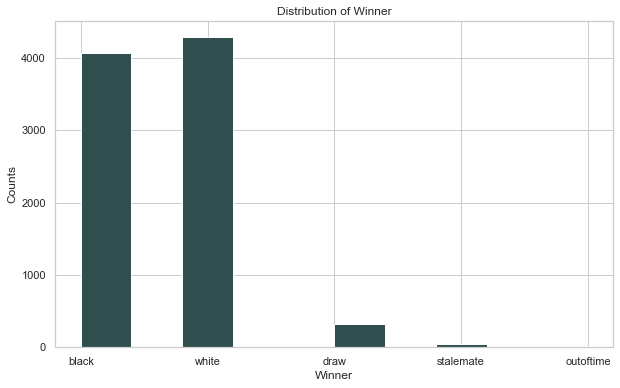

In [9]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data['winner'], color="darkslategray")
axes.set_title("Distribution of Winner")
axes.set_xlabel("Winner")
axes.set_ylabel("Counts")

plt.show()
plt.close()

We notice something unusual with our data. As expected we are seeing draw and stalemates, but out of time is a bit unexpected. For now we will rename the data to fit our expectation and our model. In our model, we are going to change the scope of our model a bit. Our y is going to be if white wins, otherwise 0 if not. So everything else will be grouped together.<br><br>
We are not sure what outoftime means, so we elect to remove it from the set.

In [10]:
data['winner'].replace({"black": 0, "white": 1, "draw": -1, "stalemate": -1, "outoftime": -1}, inplace = True)
data = data[data['winner'] != -1]
data.reset_index(drop = True, inplace = True)

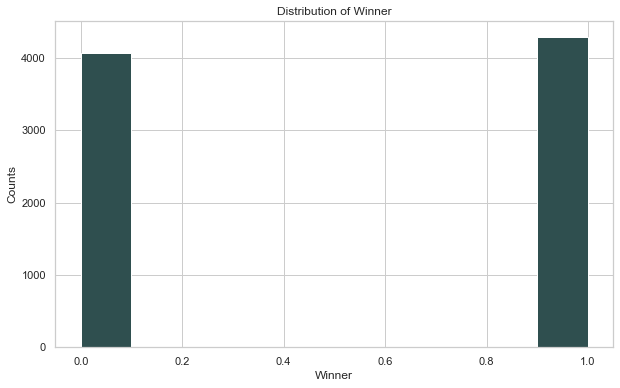

In [11]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data['winner'], color="darkslategray")
axes.set_title("Distribution of Winner")
axes.set_xlabel("Winner")
axes.set_ylabel("Counts")

plt.show()
plt.close()

We have now removed the excess variables and our model will only consider if white either wins or loses.

### White and Black Rating

For our white and black variables, we will look at them in tandem as it will be more useful.

In [12]:
data['white_rating'].describe()

count    8361.000000
mean     1841.182873
std       392.115624
min       688.000000
25%      1566.000000
50%      1880.000000
75%      2145.000000
max      3027.000000
Name: white_rating, dtype: float64

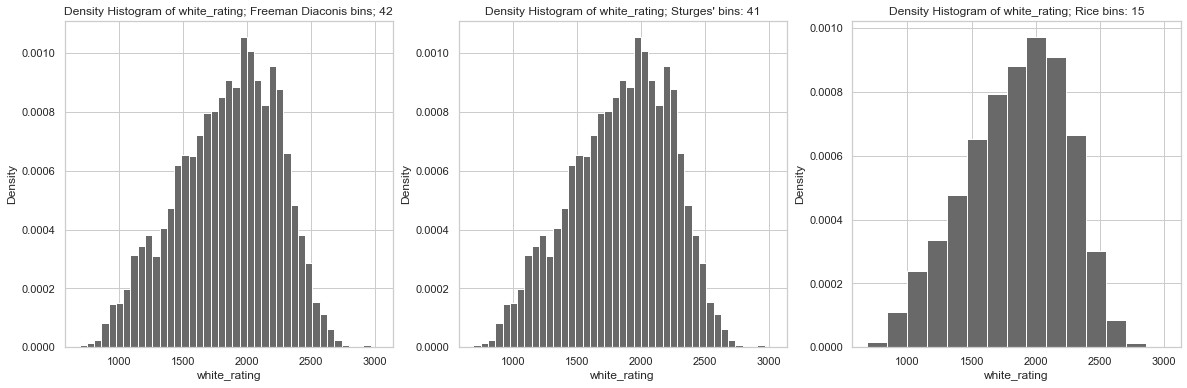

In [13]:
plot_various_bins(data, "white_rating")

In [14]:
data['black_rating'].describe()

count    8361.000000
mean     1843.583662
std       391.392952
min       697.000000
25%      1566.000000
50%      1884.000000
75%      2151.000000
max      2925.000000
Name: black_rating, dtype: float64

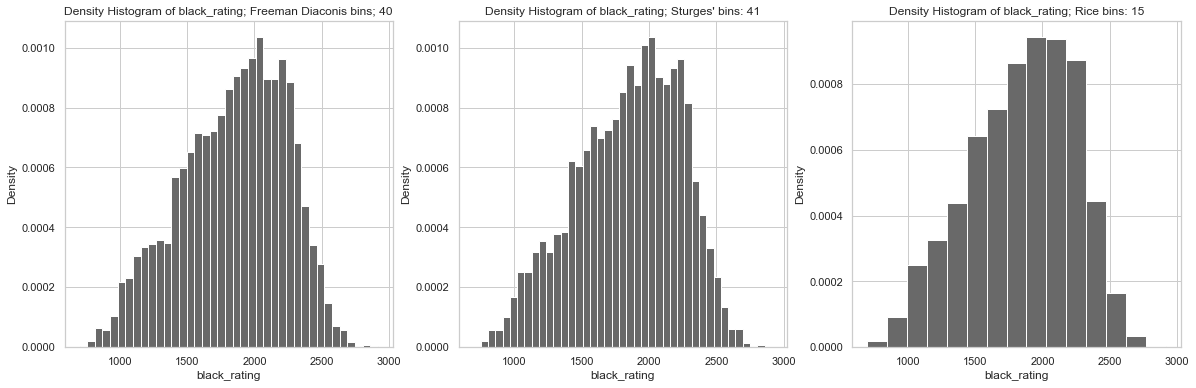

In [15]:
plot_various_bins(data, "black_rating")

Our data for ratings seems to be normalized. This in fact has more to do with the way we cultivated the data. It is not an accurate depiction of real values. This was because we intended to take the difference between the two as the main variable. We will do that now.

In [16]:
data['rating_diff'] = data['black_rating'] - data['white_rating']

In [17]:
data['rating_diff'].describe()

count    8361.000000
mean        2.400789
std       245.082031
min     -1511.000000
25%       -61.000000
50%         0.000000
75%        58.000000
max      1500.000000
Name: rating_diff, dtype: float64

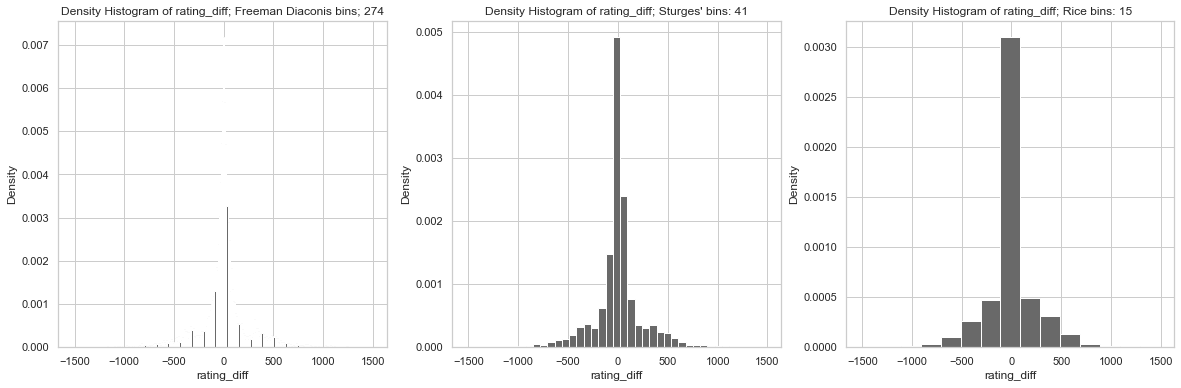

In [18]:
plot_various_bins(data, "rating_diff")

We get a much more interesting picture here. It seems our data is saying most of the games played were within a rating differential of -100 to 100. We believe it will be important to remove outliers. As it is trivially the case where a significant rating differential will impact the odds.

In [19]:
data_new = data[abs(data['rating_diff']) > 500]
print(len(data_new[(data_new['winner'] == 1) & (data_new['rating_diff'] < 0)]))
print(len(data_new[(data_new['winner'] == 1) & (data_new['rating_diff'] > 0)]))

169
96


In [20]:
for i in range(10):
    print("When Rating Diff is " + str(100 * i))
    data_new = data[abs(data['rating_diff']) > 100 * i]
    print(len(data_new[(data_new['winner'] == 1) & (data_new['rating_diff'] < 0)]))
    print(len(data_new[(data_new['winner'] == 1) & (data_new['rating_diff'] > 0)]))

When Rating Diff is 0
2274
1984
When Rating Diff is 100
900
686
When Rating Diff is 200
525
476
When Rating Diff is 300
367
409
When Rating Diff is 400
240
193
When Rating Diff is 500
169
96
When Rating Diff is 600
104
43
When Rating Diff is 700
62
13
When Rating Diff is 800
39
5
When Rating Diff is 900
24
2


We can see the threshold peaks when the rating difference peaks 500. This is the point where we may want to remove outliers in the data points.

### White and Black Number of Games

In [21]:
data['white_games'].describe()

count      8361.000000
mean       4281.783878
std        8287.953219
min           0.000000
25%         545.000000
50%        1585.000000
75%        4574.000000
max      146377.000000
Name: white_games, dtype: float64

In [22]:
data['black_games'].describe()

count      8361.000000
mean       4547.019854
std        8998.560618
min           0.000000
25%         550.000000
50%        1654.000000
75%        4816.000000
max      270321.000000
Name: black_games, dtype: float64

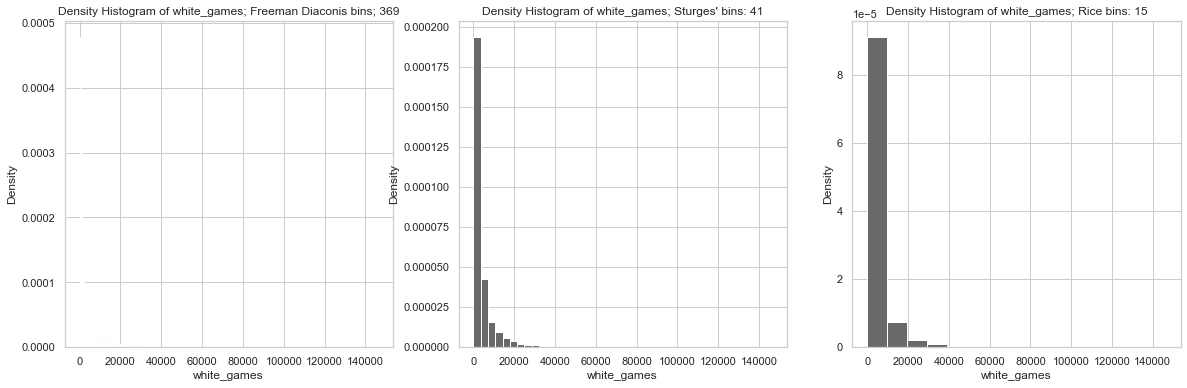

In [23]:
plot_various_bins(data, "white_games")

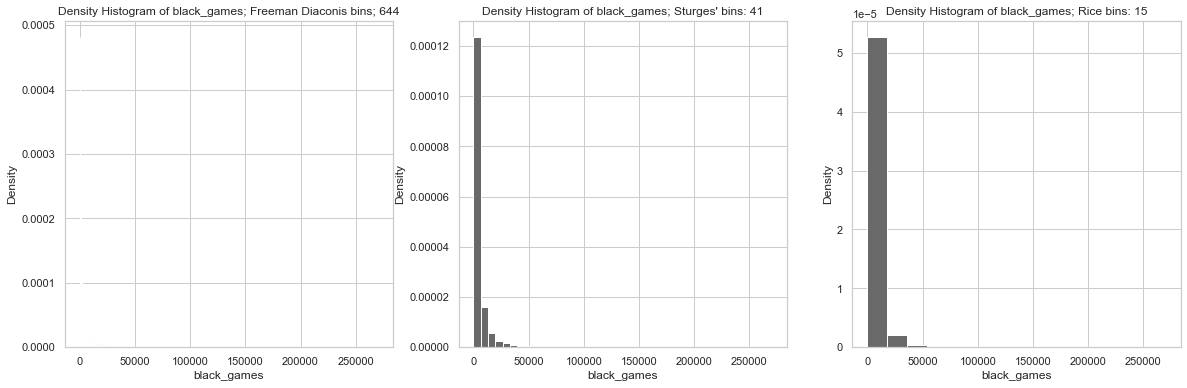

In [24]:
plot_various_bins(data, "black_games")

Here we see that there are some players who have played many games, while some who have not playeed too many. The data seems to be skewed in the sense that more players have played many games. We again take the difference in number of games.

In [25]:
data['game_diff'] = data['black_games'] - data['white_games']
data['game_diff'].describe()

count      8361.000000
mean        265.235977
std       11582.018310
min     -140779.000000
25%       -1724.000000
50%          13.000000
75%        2070.000000
max      246320.000000
Name: game_diff, dtype: float64

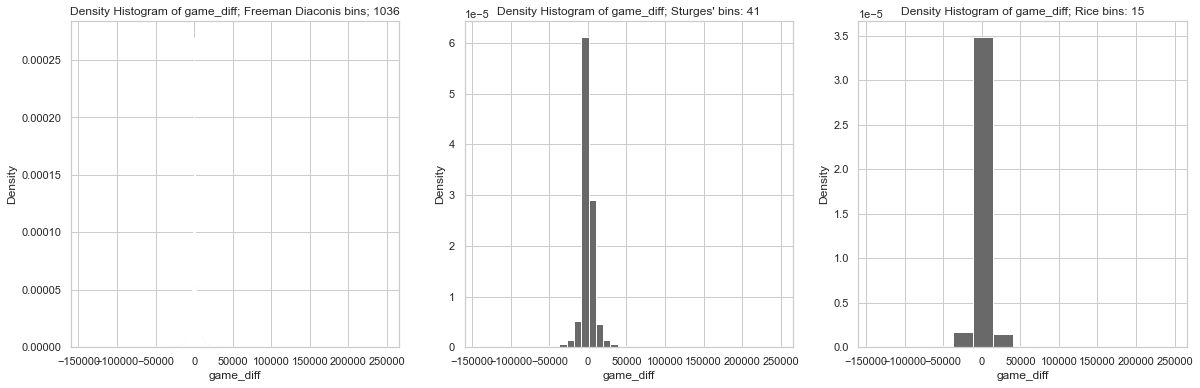

In [26]:
plot_various_bins(data, "game_diff")

In [27]:
data[abs(data['game_diff']) > 100000].loc[0:, ['white_games', 'black_games','winner']]

,white_games,black_games,winner
2135,61.0,103123.0,1
2136,103123.0,52.0,0
2137,22.0,103123.0,1
2138,247.0,103123.0,1
2139,416.0,103123.0,1
2140,103123.0,496.0,1
2377,127085.0,765.0,0
2564,2978.0,116036.0,1
3010,2044.0,115046.0,1
3569,24001.0,270321.0,1


It seems the game differential has maintains some disparity when even as the number of games increases dramatically. This may an indication to keep all data points.

### White and Black Inaccuracies

The hierarchy of move evalutations: Inaccuracy, Mistakes and Blunders. The method for how these evaluations are calculated is difficult to mark, but this is the basic hierarchy for these labels.

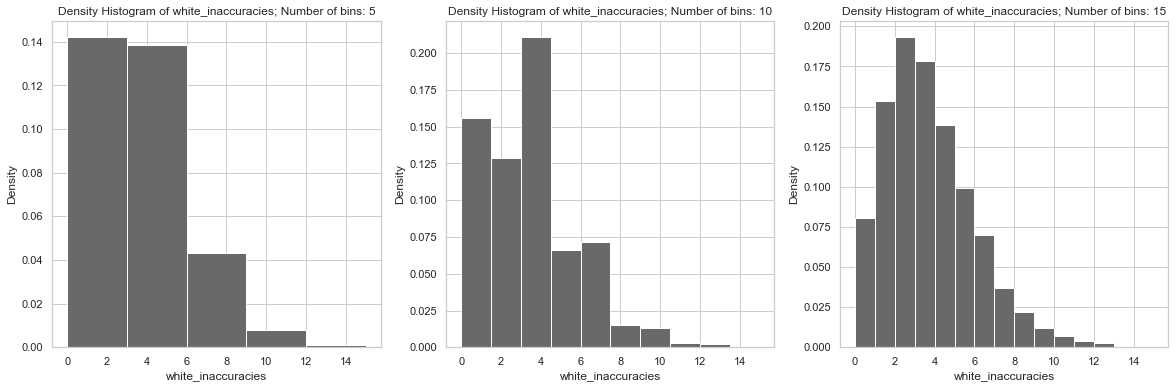

In [28]:
plot_various_bins_manual(data, 'white_inaccuracies', 5, 10, 15)

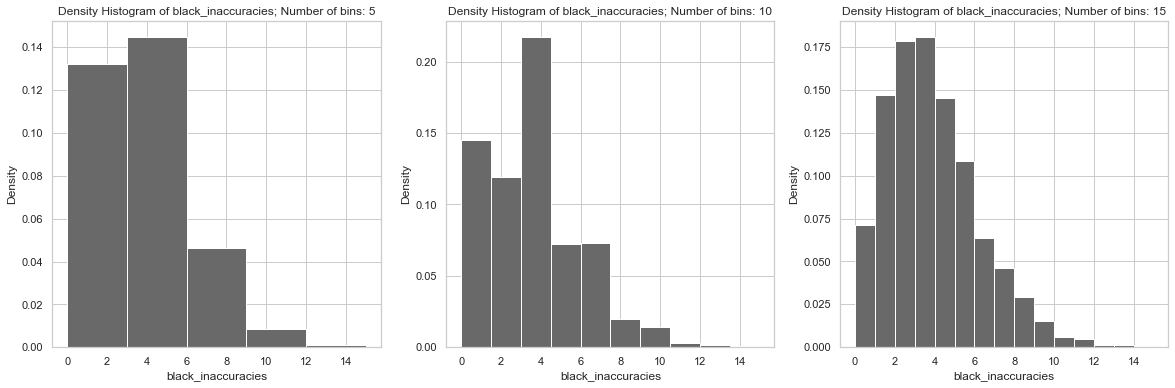

In [29]:
plot_various_bins_manual(data, 'black_inaccuracies', 5, 10, 15)

Both data variables seem to indicate that they are left skewed as expected. However, taken alone they may be useful. It may be useful to see them as a difference.

In [30]:
data['inacc_diff'] = data['black_inaccuracies'] - data['white_inaccuracies']
data['inacc_diff'].describe()

count    8361.000000
mean        0.149982
std         2.311660
min       -11.000000
25%        -1.000000
50%         0.000000
75%         2.000000
max         9.000000
Name: inacc_diff, dtype: float64

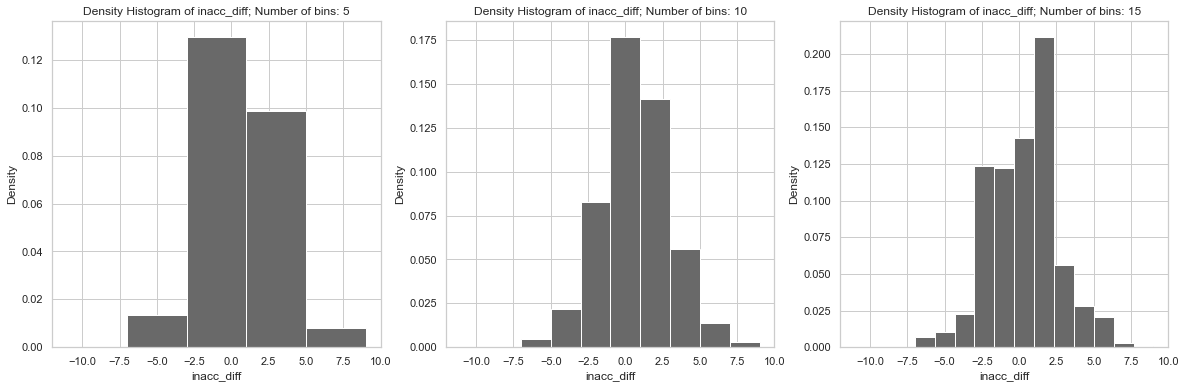

In [31]:
plot_various_bins_manual(data, 'inacc_diff', 5, 10, 15)

Taken as a difference, it seems the outcome is more normalized. This may be an indication that it works better in our model.

### White and Black Mistakes

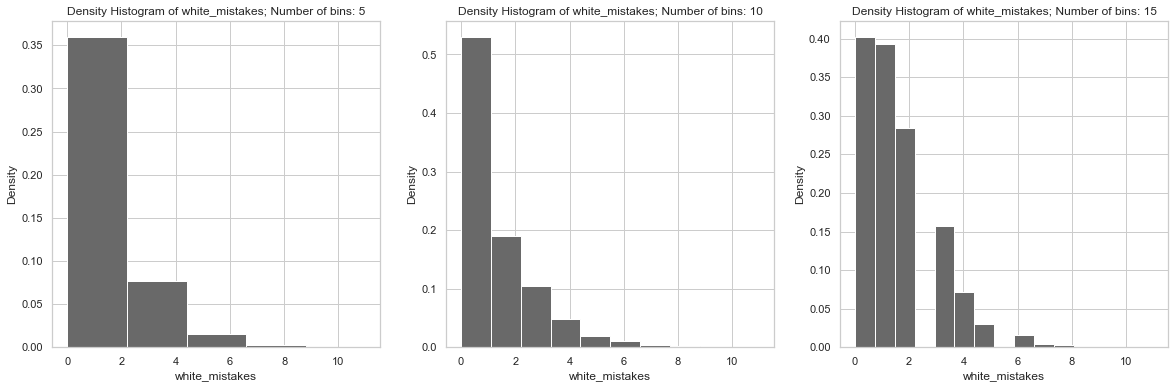

In [32]:
plot_various_bins_manual(data, 'white_mistakes', 5, 10, 15)

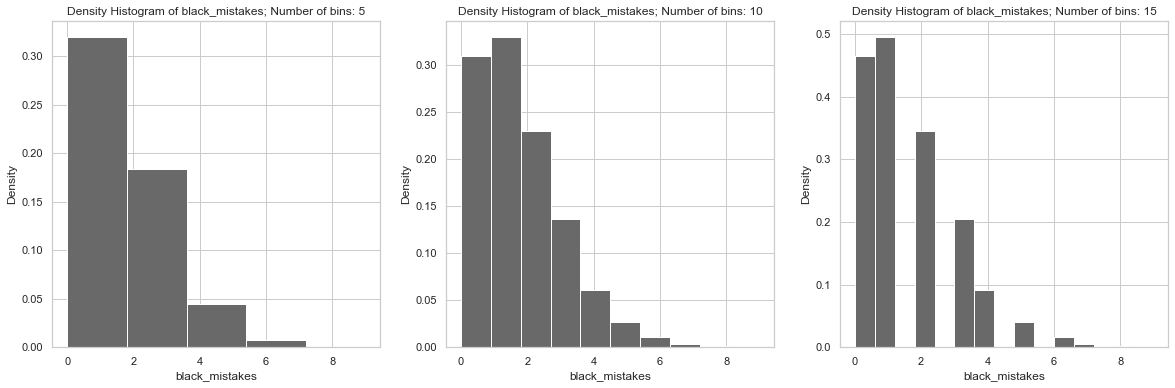

In [33]:
plot_various_bins_manual(data, 'black_mistakes', 5, 10, 15)

We see a similar distribution as the inaccuracies but with less outliers. Less mistakes are made on average which makes sense.

In [34]:
data['mistake_diff'] = data['black_mistakes'] - data['white_mistakes'] 
data['mistake_diff'].describe()

count    8361.000000
mean        0.027509
std         1.596260
min        -7.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: mistake_diff, dtype: float64

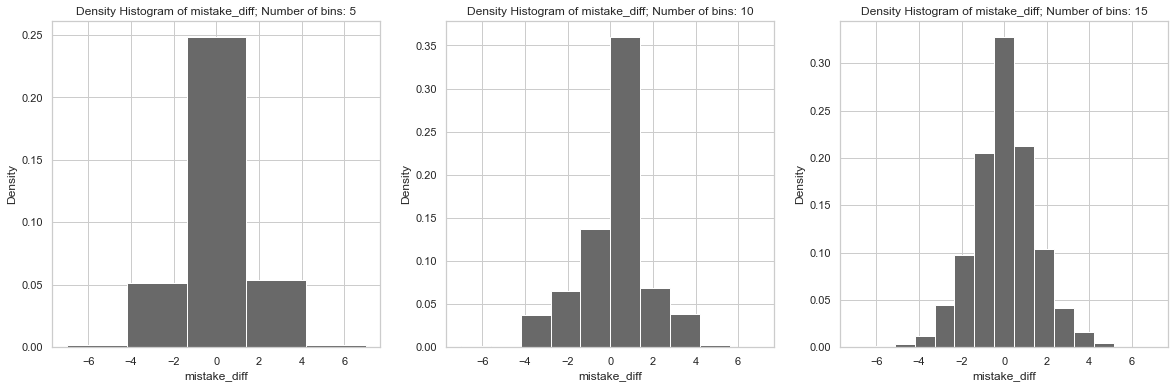

In [35]:
plot_various_bins_manual(data, 'mistake_diff', 5, 10, 15)

Again the difference in these values are highly normalized.

### White and Black Blunders

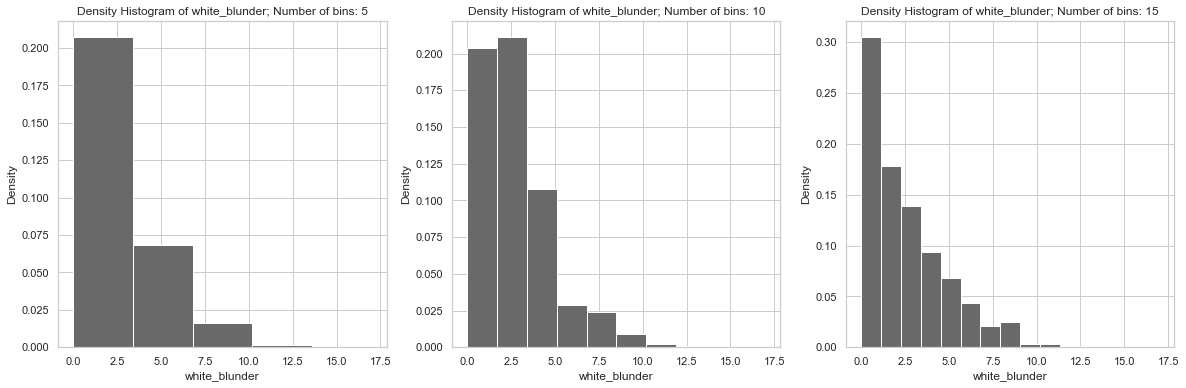

In [36]:
plot_various_bins_manual(data, 'white_blunder', 5, 10, 15)

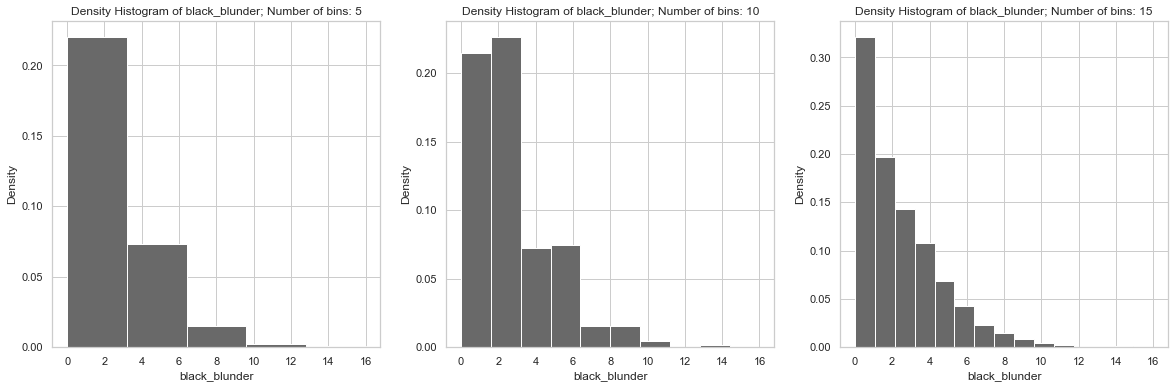

In [37]:
plot_various_bins_manual(data, 'black_blunder', 5, 10, 15)

Again we see a similar left skew as there are more cases where blunders are made.

In [38]:
data['blunder_diff'] = data['black_blunder'] - data['white_blunder'] 
data['blunder_diff'].describe()

count    8361.000000
mean       -0.009807
std         1.542352
min        -6.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         6.000000
Name: blunder_diff, dtype: float64

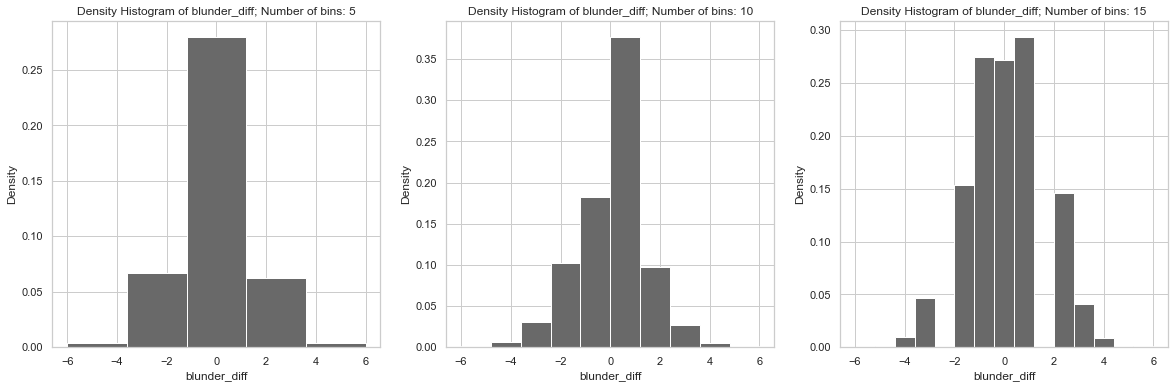

In [39]:
plot_various_bins_manual(data, 'blunder_diff', 5, 10, 15)

The difference is again highly normalized as expected.

### White and Black ACPL - Average Centipawn Loss

ACPL is a metric develop that rates your overall play. A 20 indicates near perfect play and above a 300 means you are playing at a very low, purposefully losing manner.

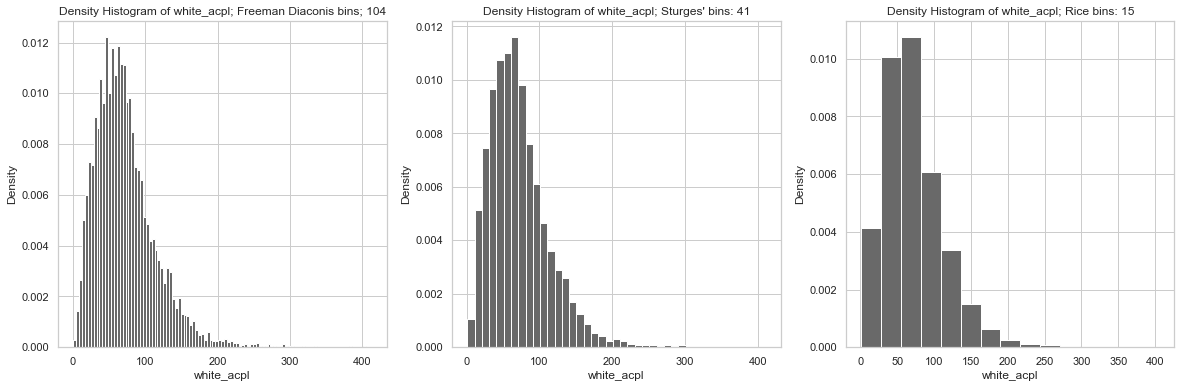

In [40]:
plot_various_bins(data, 'white_acpl')

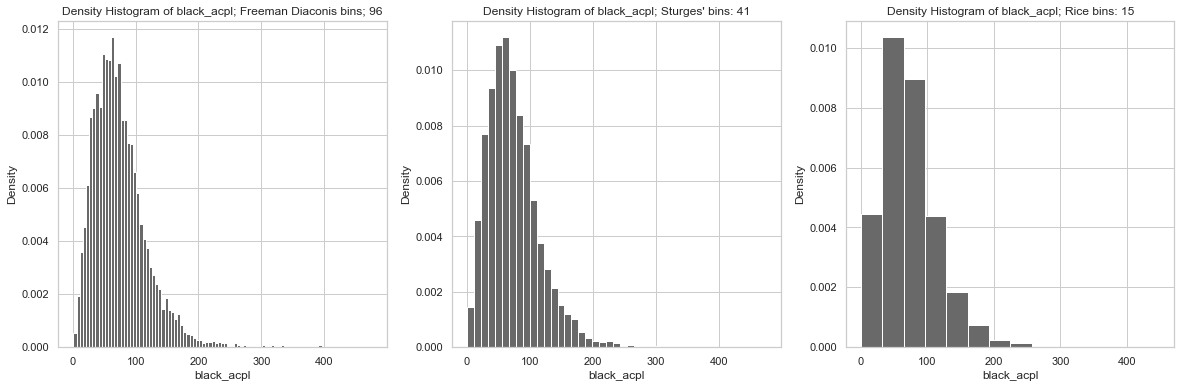

In [41]:
plot_various_bins(data, 'black_acpl')

Both white and black acpl seem be left skewed but more normal than the other metrics.

In [42]:
data['acpl_diff'] = data['black_acpl'] - data['white_acpl']
data['acpl_diff'].describe()

count    8361.000000
mean        2.234900
std        36.108301
min      -254.000000
25%       -27.000000
50%         6.000000
75%        30.000000
max       247.000000
Name: acpl_diff, dtype: float64

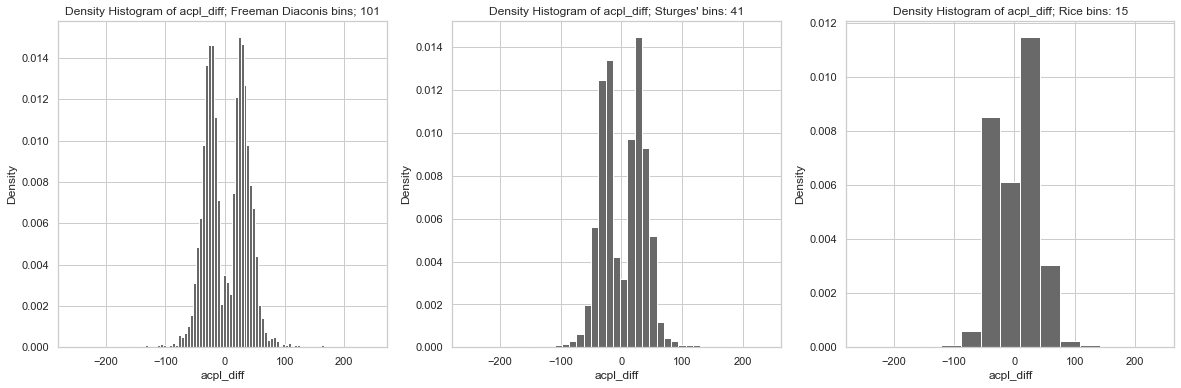

In [43]:
plot_various_bins(data, 'acpl_diff')

This is a new and very odd distribution. It seems there may be some collinearity or some other factoring causing the difference.

### White and Black Country

The data currently provides country by ISO alpha 2 code.

In [44]:
data['white_country'].describe()

count     8361
unique     185
top         IN
freq      1218
Name: white_country, dtype: object

In [45]:
data['black_country'].describe()

count     8361
unique     179
top         IN
freq      1306
Name: black_country, dtype: object

There are too many unique values for the countries. There must be a better way to group the two. My take was to group the countries by continents.

For this analysis we use a dataset that we found on github: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv

In [46]:
country_by_continent = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")

In [47]:
## Adding columns for white
data = pd.merge(data, country_by_continent.loc[0:len(country_by_continent), ['region', 'alpha-2']],
        how='left', left_on = 'white_country', right_on = 'alpha-2')
data.rename(columns = {"region": "white_region"}, inplace = True)

In [48]:
## Adding columns for black
data = pd.merge(data, country_by_continent.loc[0:len(country_by_continent), ['region', 'alpha-2']],
        how='left', left_on = 'black_country', right_on = 'alpha-2')
data.rename(columns = {"region": "black_region"}, inplace = True)

In [49]:
data['white_region'] = data['white_region'].astype(str)
data['black_region'] = data['black_region'].astype(str)

In [50]:
data.white_region.value_counts(normalize=True).sort_index()

Africa      0.090539
Americas    0.179763
Asia        0.313599
Europe      0.376869
Oceania     0.012439
nan         0.026791
Name: white_region, dtype: float64

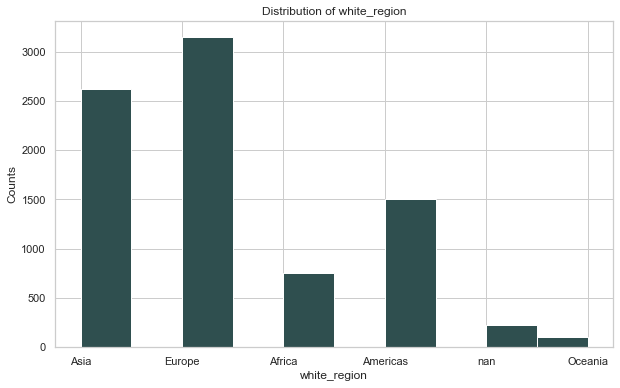

In [51]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data['white_region'], color="darkslategray")
axes.set_title("Distribution of white_region")
axes.set_xlabel("white_region")
axes.set_ylabel("Counts")

plt.show()
plt.close()

In [52]:
data.black_region.value_counts(normalize=True).sort_index()

Africa      0.087908
Americas    0.180959
Asia        0.319938
Europe      0.374477
Oceania     0.013635
nan         0.023083
Name: black_region, dtype: float64

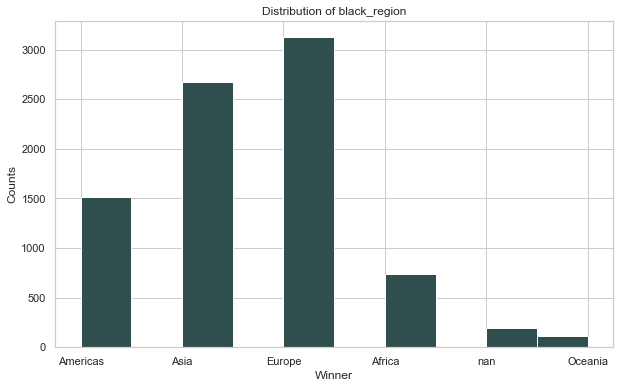

In [53]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data['black_region'], color="darkslategray")
axes.set_title("Distribution of black_region")
axes.set_xlabel("Winner")
axes.set_ylabel("Counts")

plt.show()
plt.close()

First thing we notice are some nan values. Lets see what they are.

In [54]:
data[data['white_region'] == "nan"]['white_country'].unique()

array(['EU', 'UK', 'AQ', 'UN', 'XK'], dtype=object)

In [55]:
data[data['black_region'] == "nan"]['black_country'].unique()

array(['UK', 'AQ', 'EU', 'XK', 'UN'], dtype=object)

we immediately notice these are all other terms for europe. XK is republic of kosovo, which is in europe. AQ is antartica, which is suspicious.

In [56]:
data.loc[data.white_country == ("EU"), 'white_region'] = "Europe"
data.loc[data.white_country == ("UK"), 'white_region'] = "Europe"
data.loc[data.white_country == ("UN"), 'white_region'] = "Europe"
data.loc[data.white_country == ("XK"), 'white_region'] = "Europe"
data.loc[data.white_country == ("AQ"), 'white_region'] = "Antarctica"
data.loc[data.black_country == ("EU"), 'black_region'] = "Europe"
data.loc[data.black_country == ("UK"), 'black_region'] = "Europe"
data.loc[data.black_country == ("UN"), 'black_region'] = "Europe"
data.loc[data.black_country == ("XK"), 'black_region'] = "Europe"
data.loc[data.black_country == ("AQ"), 'black_region'] = "Antarctica"
data.loc[data.black_country == ("Antarctica"), 'black_region'] = "Antarctica"

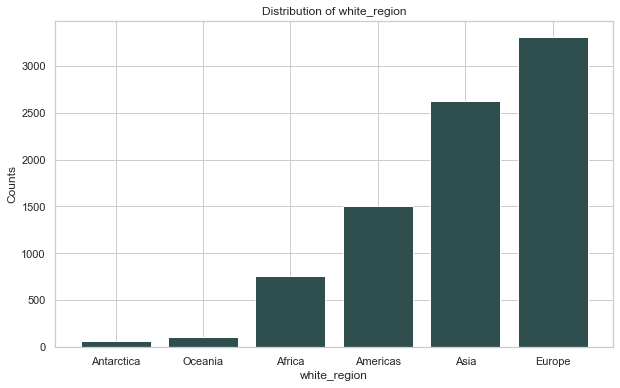

In [57]:
figure = plt.figure(figsize=(10, 6))
ticks = ['Antarctica', 'Oceania', 'Africa', 'Americas', 'Asia', 'Europe']
axes = figure.add_subplot(1, 1, 1)
axes.bar(ticks,data.groupby('white_region').size().sort_values(ascending = True), color="darkslategray")
axes.set_title("Distribution of white_region")
axes.set_xticks(['Antarctica', "Oceania", "Africa","Americas","Asia","Europe"])
axes.set_xlabel("white_region")
axes.set_ylabel("Counts")

plt.show()
plt.close()

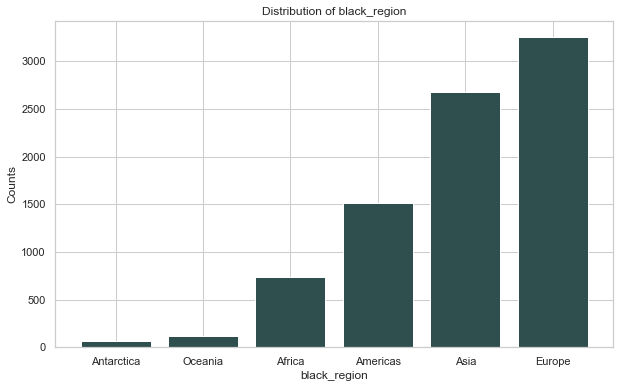

In [58]:
figure = plt.figure(figsize=(10, 6))
ticks = ['Antarctica', 'Oceania', 'Africa', 'Americas', 'Asia', 'Europe']
axes = figure.add_subplot(1, 1, 1)
axes.bar(ticks,data.groupby('black_region').size().sort_values(ascending = True), color="darkslategray")
axes.set_title("Distribution of black_region")
axes.set_xticks(['Antarctica', "Oceania", "Africa","Americas","Asia","Europe"])
axes.set_xlabel("black_region")
axes.set_ylabel("Counts")

plt.show()
plt.close()

### Game Type

We chose to only take three game types: Rapid, Blitz and Bullet

In [59]:
data.game_type.value_counts(normalize=True).sort_index()

blitz     0.462504
bullet    0.235857
rapid     0.301639
Name: game_type, dtype: float64

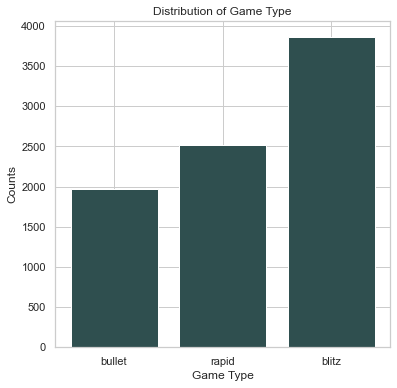

In [60]:
figure = plt.figure(figsize=(6, 6))
ticks = ['bullet', 'rapid','blitz']
axes = figure.add_subplot(1, 1, 1)
axes.bar(ticks, data.groupby('game_type').size().sort_values(ascending=True), color="darkslategray")
axes.set_title("Distribution of Game Type")
axes.set_xticks(ticks)
axes.set_xlabel("Game Type")
axes.set_ylabel("Counts")

plt.show()
plt.close()

Our game type counts were relatively well distributed, but it seems there is some variability, with the majority in blitz.

### Opening

In [61]:
len(data['opening'].unique())

1153

In [62]:
data_new = data.copy()
data_new['opening'] = data_new['opening'].str[0:9]

In [63]:
len(data_new['opening'].unique())

102

There seem to be too many values that are unique and so we decide to omit this variable. Other models may be useful for this variable, but none that we can now use.

## Pair-wise Analysis <a class="anchor" id="pair"></a>

In [64]:
## Helper Functions
import eda
def describe_by_category(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        print(grouped_y.transpose())
    else:
        print(grouped_y)
        
def print_correlations(data, numeric1, numeric2):
    print("r   = ", stats.pearsonr(data[numeric1], data[numeric2])[0])
    print("rho = ", stats.spearmanr(data[numeric1], data[numeric2])[0])
    
def graph_with_lowess(data, var1, var2):
    lowess = sm.nonparametric.lowess(data[var1], data[var2], frac=.3)
    lowess_x = list(zip(*lowess))[0]
    lowess_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 12))

    axes = figure.add_subplot(2, 1, 1)
    axes.hist(data[var1], color="darkslategray")
    axes.set_title("Distribution of " + var1)
    axes.set_xlabel(var1)
    axes.set_ylabel("Counts")


    axes = figure.add_subplot(2, 1, 2)
    axes.scatter(data[var1], data[var2], marker="o", color="DimGray")
    axes.plot(lowess_x, lowess_y, color="DarkRed")

    axes.set_title("Plot of " + var1 + " vs. " + var2 + " with LOWESS")
    axes.set_xlabel(var1)
    axes.set_ylabel("Displacement")

    plt.show()
    plt.close()
    
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    eda.restyle_boxplot( patch)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))

    plt.show()
    plt.close()    

def plot_categorical(data, cat, num):
    figure = plt.figure(figsize=(10, 12))

    axes = figure.add_subplot(2, 1, 1)
    axes.hist(data[cat], color="darkslategray")
    axes.set_title("Distribution of " + cat)
    axes.set_xlabel(cat)
    axes.set_ylabel("Counts")


    axes = figure.add_subplot(2, 1, 2)
    axes.scatter(data[cat], data[num], marker="o", color="DimGray")

    axes.set_title("Plot of "+cat+" vs. "+ num)
    axes.set_xlabel(cat)
    axes.set_ylabel(num)

    plt.show()
    plt.close()
    

### Winner vs. Rating

In [65]:
describe_by_category(data, "white_rating", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean    1820.866699  1860.415832
std      385.941667   396.959891
min      688.000000   732.000000
25%     1545.250000  1584.500000
50%     1864.000000  1894.000000
75%     2121.000000  2168.500000
max     2714.000000  3027.000000


In [66]:
describe_by_category(data, "black_rating", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean    1843.182735  1843.963213
std      396.088789   386.940751
min      697.000000   780.000000
25%     1556.000000  1577.000000
50%     1872.500000  1898.000000
75%     2152.000000  2151.000000
max     2925.000000  2804.000000


In [67]:
describe_by_category(data, "rating_diff", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean      22.316035   -16.452619
std      255.914500   232.831471
min    -1511.000000 -1363.000000
25%      -49.000000   -73.500000
50%        4.000000    -5.000000
75%       77.000000    46.000000
max     1500.000000  1370.000000


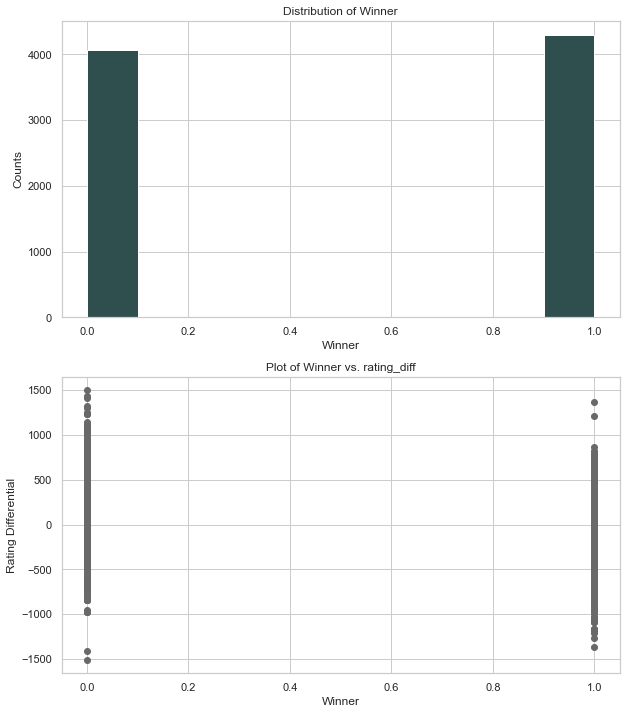

In [68]:
figure = plt.figure(figsize=(10, 12))

axes = figure.add_subplot(2, 1, 1)
axes.hist(data["winner"], color="darkslategray")
axes.set_title("Distribution of Winner")
axes.set_xlabel("Winner")
axes.set_ylabel("Counts")


axes = figure.add_subplot(2, 1, 2)
axes.scatter(data["winner"], data["rating_diff"], marker="o", color="DimGray")

axes.set_title("Plot of Winner vs. rating_diff")
axes.set_xlabel("Winner")
axes.set_ylabel("Rating Differential")

plt.show()
plt.close()

We see exactly what we expected. There does to be some indication that the rating differential will be higher (in favor of white) with more instances of winning as white.

### Winner vs. Games

In [69]:
describe_by_category(data, "white_games", "winner", transpose = True)

winner              0              1
count     4066.000000    4295.000000
mean      4377.275947    4191.383236
std       8111.101481    8451.916323
min          4.000000       0.000000
25%        581.250000     508.000000
50%       1643.000000    1544.000000
75%       4699.750000    4461.500000
max     127085.000000  146377.000000


In [70]:
describe_by_category(data, "black_games", "winner", transpose = True)

winner              0              1
count     4066.000000    4295.000000
mean      4246.869897    4831.166473
std       8403.403392    9520.055393
min          4.000000       0.000000
25%        489.500000     622.000000
50%       1454.000000    1893.000000
75%       4562.000000    5176.500000
max     128454.000000  270321.000000


In [71]:
describe_by_category(data, "game_diff", "winner", transpose = True)

winner              0              1
count     4066.000000    4295.000000
mean      -130.406050     639.783236
std      11004.398291   12092.826346
min    -126320.000000 -140779.000000
25%      -2009.000000   -1435.000000
50%       -132.500000     135.000000
75%       1588.750000    2496.000000
max     125760.000000  246320.000000


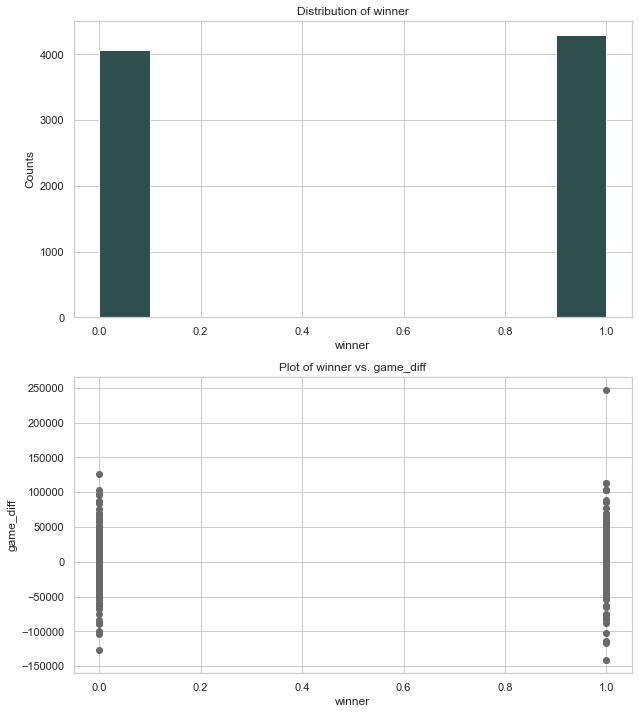

In [72]:
plot_categorical(data, 'winner', 'game_diff')

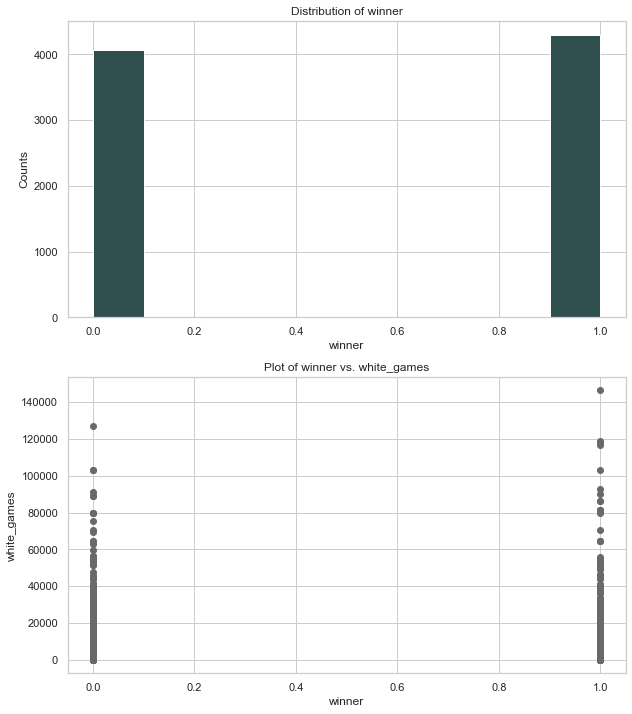

In [73]:
plot_categorical(data, 'winner', 'white_games')

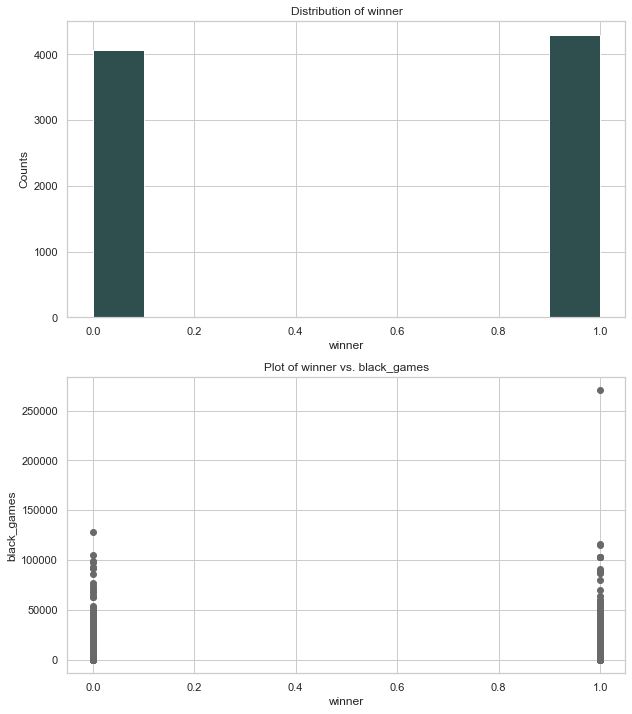

In [74]:
plot_categorical(data, 'winner', 'black_games')

The trend with games is much harder to see. Even dividing amongst white, black and the difference, it doesn't seem like there is a clear trend with wins and number of games played.

### Winner vs. Inaccuracies, Mistakes, Blunders

In [75]:
describe_by_category(data, "inacc_diff", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean      -0.382932     0.654482
std        2.266759     2.239671
min       -9.000000   -11.000000
25%       -2.000000    -1.000000
50%        0.000000     1.000000
75%        1.000000     2.000000
max        9.000000     9.000000


In [76]:
describe_by_category(data, "white_inaccuracies", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean       3.547713     2.979744
std        2.331624     2.169851
min        0.000000     0.000000
25%        2.000000     1.000000
50%        3.000000     3.000000
75%        5.000000     4.000000
max       14.000000    15.000000


Based on the means we can see something interesting. It seems that the mean for difference in inaccuracy when white wins is lower than when white loses. You can see clearly, white makes less inaccuracies when white wins. This is intuitive enough. What's interesting was that it seems when white wins the absolute difference is greater. 

In [77]:
describe_by_category(data, "mistake_diff", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean      -0.228234     0.269616
std        1.605663     1.549057
min       -7.000000    -6.000000
25%       -1.000000    -1.000000
50%        0.000000     0.000000
75%        1.000000     1.000000
max        6.000000     7.000000


In [78]:
describe_by_category(data, "white_mistakes", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean       1.652238     1.331083
std        1.499345     1.378625
min        0.000000     0.000000
25%        0.000000     0.000000
50%        1.000000     1.000000
75%        2.000000     2.000000
max       11.000000     8.000000


In [79]:
describe_by_category(data, "black_mistakes", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean       1.424004     1.600698
std        1.426771     1.416698
min        0.000000     0.000000
25%        0.000000     1.000000
50%        1.000000     1.000000
75%        2.000000     2.000000
max        9.000000     9.000000


This is more in line with what we expected. The absolute difference is around equal for both cases.

In [80]:
describe_by_category(data, "blunder_diff", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean      -0.933104     0.864261
std        1.285725     1.222734
min       -6.000000    -5.000000
25%       -2.000000     0.000000
50%       -1.000000     1.000000
75%        0.000000     2.000000
max        6.000000     6.000000


In [81]:
describe_by_category(data, "white_blunder", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean       3.220856     2.210710
std        2.164779     2.193499
min        0.000000     0.000000
25%        2.000000     0.000000
50%        3.000000     2.000000
75%        4.000000     3.000000
max       17.000000    17.000000


In [82]:
describe_by_category(data, "black_blunder", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean       2.287752     3.074971
std        2.221517     2.126411
min        0.000000     0.000000
25%        1.000000     2.000000
50%        2.000000     3.000000
75%        3.000000     4.000000
max       16.000000    16.000000


Same as mistakes with an added impact. It seems the difference in blunders is more stark and has a stronger affect on outcome of the game. This makes sense.

### Winner vs. ACPL

In [83]:
describe_by_category(data, "white_acpl", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean      86.524102    57.462864
std       40.462140    37.694392
min        7.000000     1.000000
25%       59.000000    31.000000
50%       78.000000    48.000000
75%      106.000000    75.000000
max      414.000000   298.000000


In [84]:
describe_by_category(data, "black_acpl", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean      59.753566    87.156694
std       39.904163    41.148123
min        1.000000     2.000000
25%       32.000000    59.000000
50%       50.000000    79.000000
75%       78.000000   105.000000
max      393.000000   481.000000


In [85]:
describe_by_category(data, "acpl_diff", "winner", transpose = True)

winner            0            1
count   4066.000000  4295.000000
mean     -26.770536    29.693830
std       22.305808    22.728027
min     -254.000000   -46.000000
25%      -37.000000    19.000000
50%      -27.000000    29.000000
75%      -18.000000    40.000000
max      129.000000   247.000000


This is exactly in line with what we expected. White has a lower acpl on average when he wins, and the difference is negative. When white loses, the difference is positive. It also as expected seems like there is a slight advantage for white. This is also in line with what we expect. The absolute difference in acpl is higher for when white wins. In other words, black tends to play worse and white a little better. Than in the other case.

### Winner vs. Region

In [86]:
result1 = pd.crosstab( data[ "white_region"], data[ "winner"]).apply(lambda r: r/len(data), axis=1)
print(pd.crosstab( data[ "white_region"], data[ "winner"]).apply(lambda r: r/len(data), axis=1))

winner               0         1
white_region                    
Africa        0.046286  0.044253
Americas      0.086114  0.093649
Antarctica    0.004066  0.003708
Asia          0.155364  0.158235
Europe        0.188016  0.207870
Oceania       0.006459  0.005980


In [87]:
result2 = pd.crosstab( data[ "black_region"], data[ "winner"]).apply(lambda r: r/len(data), axis=1)
print(pd.crosstab( data[ "black_region"], data[ "winner"]).apply(lambda r: r/len(data), axis=1))

winner               0         1
black_region                    
Africa        0.038034  0.049874
Americas      0.092333  0.088626
Antarctica    0.002990  0.004904
Asia          0.149504  0.170434
Europe        0.196508  0.193159
Oceania       0.006937  0.006698


winner               0         1
white_region                    
Africa        0.046286  0.044253
Americas      0.086114  0.093649
Antarctica    0.004066  0.003708
Asia          0.155364  0.158235
Europe        0.188016  0.207870
Oceania       0.006459  0.005980


<AxesSubplot:xlabel='winner', ylabel='white_region'>

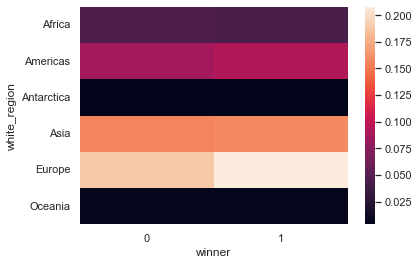

In [88]:
print(result1)
sns.heatmap(result1)

winner               0         1
black_region                    
Africa        0.038034  0.049874
Americas      0.092333  0.088626
Antarctica    0.002990  0.004904
Asia          0.149504  0.170434
Europe        0.196508  0.193159
Oceania       0.006937  0.006698


<AxesSubplot:xlabel='winner', ylabel='black_region'>

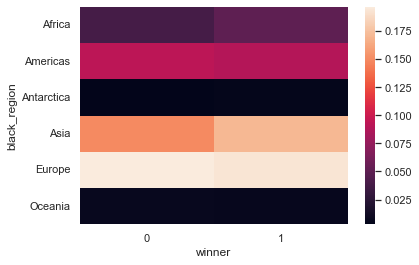

In [89]:
print(result2)
sns.heatmap(result2)

For the most part for each region, the counts of white wins is the same. The biggest difference, however seems to be in asia.

In [90]:
data['same_region'] = np.where(data['white_region'] == data['black_region'], "yes", "no")

In [91]:
data['same_region'].value_counts(normalize=True).sort_index()

no     0.603158
yes    0.396842
Name: same_region, dtype: float64

In [92]:
result3 = pd.crosstab( data[ "same_region"], data[ "winner"]).apply(lambda r: r/len(data), axis=1)
print(result3)

winner              0         1
same_region                    
no           0.299725  0.303433
yes          0.186581  0.210262


In [93]:
data['same_country'] = np.where(data['white_country'] == data['black_country'], "yes", "no")

In [94]:
data['same_country'].value_counts(normalize=True).sort_index()

no     0.862935
yes    0.137065
Name: same_country, dtype: float64

In [95]:
result4 = pd.crosstab( data[ "same_country"], data[ "winner"]).apply(lambda r: r/len(data), axis=1)
print(result4)

winner               0         1
same_country                    
no            0.423155  0.439780
yes           0.063150  0.073915


We see that there seems to be a difference in white performance when white and black are from the same region. I initially thought maybe its because of lack of disparity, but actually as you can see, there are many games where white and black come from the same region (which makes sense as you play during certain times). When they are from the same country, however the performance is the same.

### Winner vs. Game type

game_type     blitz    bullet     rapid
winner                                 
0          0.220667  0.115417  0.150221
1          0.241837  0.120440  0.151417


<AxesSubplot:xlabel='game_type', ylabel='winner'>

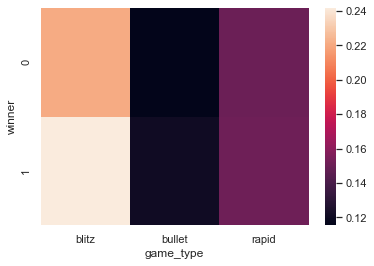

In [96]:
result3 = pd.crosstab( data[ "winner"], data[ "game_type"]).apply(lambda r: r/len(data), axis=1)
print(pd.crosstab( data[ "winner"], data[ "game_type"]).apply(lambda r: r/len(data), axis=1))
sns.heatmap(result3)

In general there does not seem to be a big difference by game_type. I suspect game type will play more of a factor as an interaction term.

# Model <a class="anchor" id="model"></a>

We begin with the null model. Because 

In [97]:
def logistic( z):
    return 1.0 / (1.0 + np.exp( -z))

def log( x):
    return np.log(float( x))

## Null Model <a class="anchor" id="null"></a>

As we learned in class for our null model we start with our mean. We use the bernoulli distribution as the baseline model for our null hypothesis.

In [98]:
winner_mean = np.mean(data.winner)
print("p = ", winner_mean)

p =  0.5136945341466331


This means that there is a 51.4% chance that white will win the next chess match.

## Logistic Regression <a class="anchor" id="log"></a>

In [99]:
import models
import math
def mean_center( df, variable):
    x_bar = df[ variable].mean()
    scaled_variable = df[ variable] - x_bar
    df[ variable + "_centered"] = scaled_variable
    
def logistic_slope_at( beta, z):
    return (beta * np.exp( beta * z)) / (1.0 + np.exp( beta * z))**2

def unit_change(model, data):
    index = 0
    for variable in model['variables'][1:]:
        print(variable)
        a = logistic(model['coefficients'][0] + model['coefficients'][index] * np.mean(data[variable]))
        if variable == "blitz" or variable == "rapid" or variable == "same_region_yes":
            c = -1
        else:
            c = 1
        b = logistic(model['coefficients'][0] + model['coefficients'][index] * (np.mean(data[variable]) + c))
        print("Unit Difference: " + str(round((a-b), 4)))
        index += 1


We start with the model that includes all of the variables we will use. We will use the models python file and logisitic regression for our model building.

For our model we will use the difference variables (rating, games, inacc, mistakes, etc.), the game type, and the regions. First we encode the game type and regions.

In [100]:
data_model = pd.concat([data, pd.get_dummies(data["game_type"])], axis=1)
data_model = pd.concat([data_model, pd.get_dummies(data["white_region"], prefix="white")], axis=1)
data_model = pd.concat([data_model, pd.get_dummies(data["black_region"], prefix="black")], axis=1)
data_model = pd.concat([data_model, pd.get_dummies(data["same_region"], prefix="same_region")], axis=1)

In [101]:
data_model.drop(columns = ['gameid', 'white_id', 'white_country', 'black_id', 'opening',
                 'black_country', 'win_by', 'alpha-2_x', 'alpha-2_y', 'game_type',
                'white_win_last_10',
                'black_games', 'black_win_last_10', 'black_rating', 'black_inaccuracies',
                'black_mistakes', 'black_blunder', 'black_acpl'], 
                inplace=True)

Now we have encoded our variables.

Lets try to build a model

In [102]:
model1 = models.bootstrap_logistic_regression("winner ~ white_rating + white_games + rating_diff + game_diff + inacc_diff + mistake_diff + blunder_diff + acpl_diff + same_region_yes + blitz + rapid" , data_model)
models.describe_bootstrap_lgr(model1)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,-0.00,-0.04,0.00,0.50
white_rating,$\beta_{1}$,-0.00,-0.00,-0.00,-0.00
white_games,$\beta_{2}$,0.00,-0.00,0.00,0.00
rating_diff,$\beta_{3}$,0.00,0.00,0.00,0.00
game_diff,$\beta_{4}$,0.00,0.00,0.00,0.00
inacc_diff,$\beta_{5}$,0.00,-0.02,0.09,0.00
mistake_diff,$\beta_{6}$,0.00,-0.03,0.11,0.00
blunder_diff,$\beta_{7}$,0.00,0.00,0.28,0.00
acpl_diff,$\beta_{8}$,0.10,0.09,0.11,0.03


In [103]:
model2 = models.bootstrap_logistic_regression("winner ~ white_rating + white_games + rating_diff + game_diff + inacc_diff + mistake_diff + blunder_diff + acpl_diff + same_region_yes + blitz + rapid" , data_model)
models.describe_bootstrap_lgr(model2, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,-0.000,-0.042,-0.000,0.500
white_rating,$\beta_{1}$,-0.000,-0.000,-0.000,-0.000
white_games,$\beta_{2}$,0.000,-0.000,0.000,0.000
rating_diff,$\beta_{3}$,0.001,0.001,0.001,0.000
game_diff,$\beta_{4}$,0.000,0.000,0.000,0.000
inacc_diff,$\beta_{5}$,0.002,0.002,0.090,0.000
mistake_diff,$\beta_{6}$,0.001,-0.021,0.135,0.000
blunder_diff,$\beta_{7}$,0.003,0.003,0.291,0.001
acpl_diff,$\beta_{8}$,0.104,0.090,0.108,0.026


### Mean Centering

We can also mean center quite a few variables to mean center. We choose to mean center as the values should be scaled.

In [104]:
mean_center(data_model, "rating_diff")
mean_center(data_model, "game_diff")
mean_center(data_model, "inacc_diff")
mean_center(data_model, "mistake_diff")
mean_center(data_model, "blunder_diff")
mean_center(data_model, "acpl_diff")
mean_center(data_model, "white_rating")
mean_center(data_model, "white_games")
mean_center(data_model, "white_inaccuracies")
mean_center(data_model, "white_mistakes")
mean_center(data_model, "white_blunder")
mean_center(data_model, "white_acpl")

In [105]:
model2 = models.bootstrap_logistic_regression("winner ~ white_rating_centered + white_games_centered + rating_diff_centered + game_diff_centered + inacc_diff_centered + mistake_diff_centered + blunder_diff_centered + acpl_diff_centered + same_region_yes + blitz + rapid" , data_model)
models.describe_bootstrap_lgr(model2)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.08,0.00,0.13,0.52
white_rating_centered,$\beta_{1}$,0.00,0.00,0.00,0.00
white_games_centered,$\beta_{2}$,0.00,-0.00,0.00,0.00
rating_diff_centered,$\beta_{3}$,0.00,0.00,0.00,0.00
game_diff_centered,$\beta_{4}$,0.00,0.00,0.00,0.00
inacc_diff_centered,$\beta_{5}$,0.07,0.00,0.09,0.02
mistake_diff_centered,$\beta_{6}$,0.02,-0.03,0.09,0.01
blunder_diff_centered,$\beta_{7}$,0.16,0.00,0.28,0.04
acpl_diff_centered,$\beta_{8}$,0.10,0.09,0.11,0.02


In [106]:
model3 = models.bootstrap_logistic_regression("winner ~ white_rating_centered + white_games_centered + rating_diff_centered + game_diff_centered + inacc_diff_centered + mistake_diff_centered + blunder_diff_centered + acpl_diff_centered + same_region_yes + blitz + rapid" , data_model)
models.describe_bootstrap_lgr(model3, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.080,0.000,0.136,0.520
white_rating_centered,$\beta_{1}$,0.000,0.000,0.001,0.000
white_games_centered,$\beta_{2}$,0.000,0.000,0.000,0.000
rating_diff_centered,$\beta_{3}$,0.001,0.001,0.001,0.000
game_diff_centered,$\beta_{4}$,0.000,0.000,0.000,0.000
inacc_diff_centered,$\beta_{5}$,0.073,0.002,0.093,0.018
mistake_diff_centered,$\beta_{6}$,0.022,-0.028,0.115,0.005
blunder_diff_centered,$\beta_{7}$,0.160,0.003,0.268,0.040
acpl_diff_centered,$\beta_{8}$,0.097,0.092,0.109,0.024


To analyze our model we will look at unit change.

In [107]:
unit_change(model3, data_model)

white_rating_centered
Unit Difference: -0.0198
white_games_centered
Unit Difference: -0.0001
rating_diff_centered
Unit Difference: -0.0
game_diff_centered
Unit Difference: -0.0003
inacc_diff_centered
Unit Difference: -0.0
mistake_diff_centered
Unit Difference: -0.0182
blunder_diff_centered
Unit Difference: -0.0055
acpl_diff_centered
Unit Difference: -0.0397
same_region_yes
Unit Difference: 0.0242
blitz
Unit Difference: 0.0176
rapid
Unit Difference: 0.0043


### Unit Change

Analyzing the probability by increasing the change in number for the differnt mean centered variables. For the inaccuracies, mistakes and blunders one unit change is sufficient to show actual change. For rating, game and acpl we create different metrics.

In [108]:
data_model['rating_diff_centered100'] = data_model['rating_diff_centered']/100
data_model['game_diff_centered1000'] = data_model['game_diff_centered']/1000
data_model['game_diff_centered10000'] = data_model['game_diff_centered']/10000
data_model['acpl_diff_centered10'] = data_model['acpl_diff_centered']/10
data_model['white_rating_centered100'] = data_model['white_rating_centered']/100
data_model['white_games_centered1000'] = data_model['white_games_centered']/1000
data_model['white_acpl_centered10'] = data_model['white_acpl_centered']/10

In [109]:
data_model['white_games_centered10000'] = data_model['white_games_centered']/10000

In [110]:
model4 = models.bootstrap_logistic_regression("winner ~ white_rating_centered100 + white_games_centered1000 + rating_diff_centered100 + game_diff_centered1000 + inacc_diff_centered + mistake_diff_centered + blunder_diff_centered + acpl_diff_centered10 + same_region_yes + blitz + rapid" , data_model)
models.describe_bootstrap_lgr(model4, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.107,-0.165,0.357,0.527
white_rating_centered100,$\beta_{1}$,0.037,0.013,0.062,0.009
white_games_centered1000,$\beta_{2}$,0.012,-0.003,0.028,0.003
rating_diff_centered100,$\beta_{3}$,0.117,0.082,0.155,0.029
game_diff_centered1000,$\beta_{4}$,0.029,0.020,0.039,0.007
inacc_diff_centered,$\beta_{5}$,0.054,0.023,0.087,0.014
mistake_diff_centered,$\beta_{6}$,0.090,0.040,0.138,0.022
blunder_diff_centered,$\beta_{7}$,0.227,0.143,0.283,0.057
acpl_diff_centered10,$\beta_{8}$,0.942,0.900,0.999,0.235


In [111]:
unit_change(model4, data_model)

white_rating_centered100
Unit Difference: -0.0265
white_games_centered1000
Unit Difference: -0.0091
rating_diff_centered100
Unit Difference: -0.003
game_diff_centered1000
Unit Difference: -0.0291
inacc_diff_centered
Unit Difference: -0.0073
mistake_diff_centered
Unit Difference: -0.0135
blunder_diff_centered
Unit Difference: -0.0222
acpl_diff_centered10
Unit Difference: -0.0561
same_region_yes
Unit Difference: 0.2312
blitz
Unit Difference: 0.062
rapid
Unit Difference: -0.0375


In [112]:
model6 = models.bootstrap_logistic_regression("winner ~ inacc_diff_centered + mistake_diff_centered + blunder_diff_centered + acpl_diff_centered10" , data_model)
models.describe_bootstrap_lgr(model6, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.129,0.057,0.229,0.532
inacc_diff_centered,$\beta_{1}$,0.044,0.015,0.082,0.011
mistake_diff_centered,$\beta_{2}$,0.078,0.020,0.122,0.020
blunder_diff_centered,$\beta_{3}$,0.210,0.159,0.295,0.053
acpl_diff_centered10,$\beta_{4}$,0.913,0.864,0.962,0.228
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),7.954,7.354,8.664,,
Efron's $R^2$,0.737,0.719,0.755,,


In [113]:
unit_change(model6, data_model)

inacc_diff_centered
Unit Difference: -0.0319
mistake_diff_centered
Unit Difference: -0.0108
blunder_diff_centered
Unit Difference: -0.0195
acpl_diff_centered10
Unit Difference: -0.0518


## Looking At Each Term:

In [114]:
model_percentage_points = []
variable = []

In [115]:
model8 = models.bootstrap_logistic_regression("winner ~ white_rating_centered100" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.055,0.013,0.098,0.514
white_rating_centered100,$\beta_{1}$,0.026,0.016,0.035,0.006
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),48.367,47.140,49.496,,
Efron's $R^2$,0.003,0.001,0.005,,


In [116]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [117]:
model8 = models.bootstrap_logistic_regression("winner ~ white_games_centered1000" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.055,0.012,0.099,0.514
white_games_centered1000,$\beta_{1}$,-0.003,-0.008,0.002,-0.001
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),48.726,47.420,49.551,,
Efron's $R^2$,0.000,0.000,0.001,,


In [118]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [119]:
model8 = models.bootstrap_logistic_regression("winner ~ rating_diff_centered100" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.055,0.020,0.099,0.514
rating_diff_centered100,$\beta_{1}$,-0.066,-0.081,-0.047,-0.016
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),46.298,45.268,47.556,,
Efron's $R^2$,0.006,0.003,0.010,,


In [120]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [121]:
model8 = models.bootstrap_logistic_regression("winner ~ game_diff_centered1000" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.055,0.017,0.099,0.514
game_diff_centered1000,$\beta_{1}$,0.006,0.003,0.009,0.001
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),48.021,47.097,48.874,,
Efron's $R^2$,0.001,0.000,0.003,,


In [122]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [123]:
model8 = models.bootstrap_logistic_regression("winner ~ same_region_yes" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.012,-0.039,0.071,0.503
same_region_yes,$\beta_{1}$,0.107,0.022,0.188,0.027
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),48.631,47.638,49.208,,
Efron's $R^2$,0.001,0.000,0.002,,


In [124]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [125]:
model8 = models.bootstrap_logistic_regression("winner ~ white_inaccuracies_centered" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.054,0.009,0.101,0.514
white_inaccuracies_centered,$\beta_{1}$,-0.112,-0.133,-0.094,-0.028
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),44.839,43.766,45.808,,
Efron's $R^2$,0.016,0.011,0.022,,


In [126]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [127]:
model8 = models.bootstrap_logistic_regression("winner ~ white_mistakes_centered" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.054,0.016,0.108,0.514
white_mistakes_centered,$\beta_{1}$,-0.156,-0.186,-0.129,-0.039
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),44.373,43.348,45.801,,
Efron's $R^2$,0.012,0.008,0.018,,


In [128]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [129]:
model8 = models.bootstrap_logistic_regression("winner ~ white_blunder_centered" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.048,0.011,0.095,0.512
white_blunder_centered,$\beta_{1}$,-0.217,-0.243,-0.198,-0.054
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),40.378,39.652,42.396,,
Efron's $R^2$,0.054,0.045,0.063,,


In [130]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [131]:
model8 = models.bootstrap_logistic_regression("winner ~ white_acpl_centered10" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.022,-0.023,0.065,0.506
white_acpl_centered10,$\beta_{1}$,-0.210,-0.230,-0.194,-0.053
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),34.625,33.465,35.680,,
Efron's $R^2$,0.141,0.124,0.157,,


In [132]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [133]:
model8 = models.bootstrap_logistic_regression("winner ~ inacc_diff" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.027,-0.012,0.084,0.507
inacc_diff,$\beta_{1}$,0.206,0.185,0.229,0.052
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),40.282,39.130,41.448,,
Efron's $R^2$,0.051,0.042,0.061,,


In [134]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [135]:
model8 = models.bootstrap_logistic_regression("winner ~ mistake_diff_centered" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.056,0.019,0.101,0.514
mistake_diff_centered,$\beta_{1}$,0.201,0.173,0.228,0.050
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),42.411,41.364,43.369,,
Efron's $R^2$,0.025,0.018,0.031,,


In [136]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [137]:
model8 = models.bootstrap_logistic_regression("winner ~ blunder_diff_centered" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.077,0.031,0.125,0.519
blunder_diff_centered,$\beta_{1}$,1.141,1.090,1.195,0.285
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),21.971,21.099,22.814,,
Efron's $R^2$,0.383,0.365,0.401,,


In [138]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [139]:
model8 = models.bootstrap_logistic_regression("winner ~ acpl_diff_centered" , data_model)
models.describe_bootstrap_lgr(model8, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.139,0.045,0.202,0.535
acpl_diff_centered,$\beta_{1}$,0.101,0.097,0.106,0.025
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),7.726,7.213,8.355,,
Efron's $R^2$,0.735,0.717,0.754,,


In [140]:
model_percentage_points.append(model8['coefficients'][1]/4)
variable.append(model8['variables'][1])

In [141]:
variable_scores = {}
for x in range(len(variable)):
    variable_scores[variable[x]] = model_percentage_points[x]

In [142]:
model_vars = pd.DataFrame(model_percentage_points, index = variable, columns = ["Probability Change"])

In [143]:
model_vars

,Probability Change
white_rating_centered100,0.006442
white_games_centered1000,-0.000677
rating_diff_centered100,-0.016399
game_diff_centered1000,0.001465
same_region_yes,0.026748
white_inaccuracies_centered,-0.028104
white_mistakes_centered,-0.038923
white_blunder_centered,-0.054338
white_acpl_centered10,-0.052568
inacc_diff,0.051539


In [144]:
model_vars["Probability Change"].sort_values(ascending = False)

blunder_diff_centered          0.285229
inacc_diff                     0.051539
mistake_diff_centered          0.050369
same_region_yes                0.026748
acpl_diff_centered             0.025284
white_rating_centered100       0.006442
game_diff_centered1000         0.001465
white_games_centered1000      -0.000677
rating_diff_centered100       -0.016399
white_inaccuracies_centered   -0.028104
white_mistakes_centered       -0.038923
white_acpl_centered10         -0.052568
white_blunder_centered        -0.054338
Name: Probability Change, dtype: float64

In [145]:
model_percentage_points.sort()

In [146]:
model_percentage_points

[-0.05433764653617049,
 -0.05256777375085037,
 -0.038922855859790245,
 -0.028104134401569388,
 -0.016399209961218228,
 -0.0006771145358663653,
 0.0014654082512142183,
 0.006441981597565062,
 0.02528418284922149,
 0.0267480142078704,
 0.050369011709679154,
 0.051538997451799025,
 0.28522928089982613]

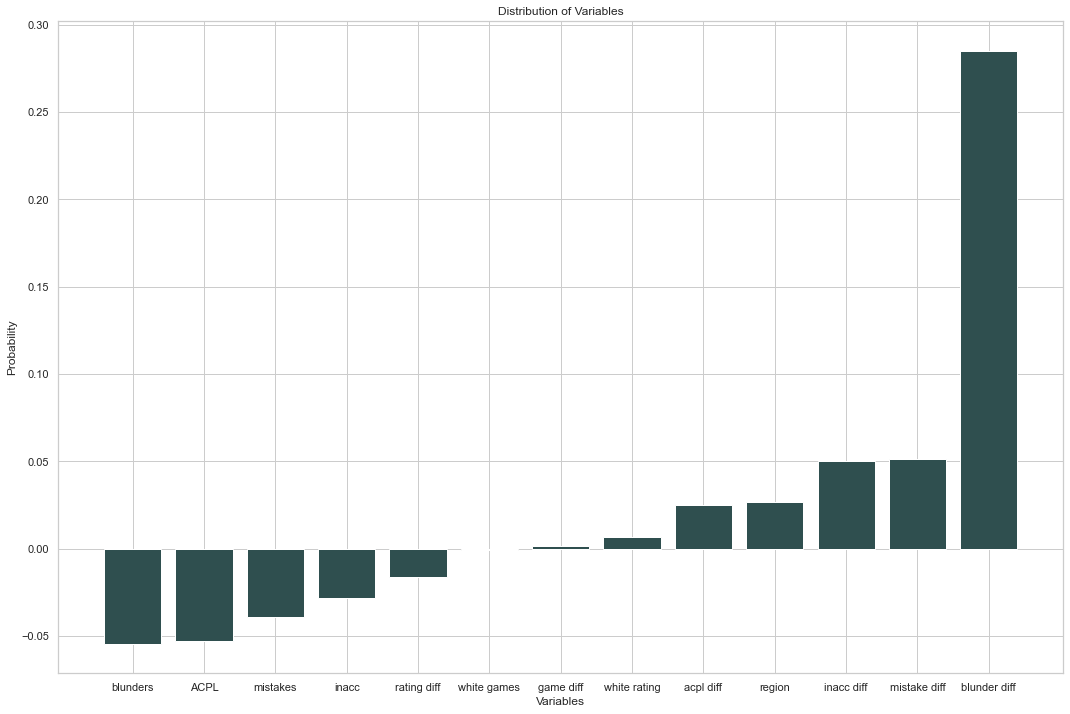

In [147]:
figure = plt.figure(figsize=(18, 12))
ticks = ['blunders', 'ACPL', 'mistakes', "inacc", "rating diff", "white games", "game diff", 
          "white rating",  'acpl diff',"region",
          'inacc diff', 'mistake diff', 'blunder diff']
axes = figure.add_subplot(1, 1, 1)
axes.bar(ticks,model_percentage_points, color="darkslategray")
axes.set_title("Distribution of Variables")
axes.set_xticks(ticks)
axes.set_xlabel("Variables")
axes.set_ylabel("Probability")

plt.show()
plt.close()

## Final Model

In [148]:
formula = "winner ~ game_diff_centered1000 + white_rating_centered100 + blunder_diff_centered + same_region_yes"
model9 = models.bootstrap_logistic_regression(formula, data_model)
models.describe_bootstrap_lgr(model9, sd = 3)

,,,95% BCI</strong,,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong,P(y=1)</strong
,$\beta_{0}$,0.031,-0.033,0.109,0.508
game_diff_centered1000,$\beta_{1}$,0.010,0.005,0.015,0.003
white_rating_centered100,$\beta_{2}$,0.017,0.004,0.034,0.004
blunder_diff_centered,$\beta_{3}$,1.143,1.101,1.195,0.286
same_region_yes,$\beta_{4}$,0.117,-0.022,0.245,0.029
,,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,,
Error (%),21.373,20.231,22.430,,
Efron's $R^2$,0.385,0.369,0.407,,


In [149]:
unit_change(model9, data_model)

game_diff_centered1000
Unit Difference: -0.0078
white_rating_centered100
Unit Difference: -0.0026
blunder_diff_centered
Unit Difference: -0.0043
same_region_yes
Unit Difference: 0.2776


## Model Validation <a class="anchor" id="validation"></a>

In [150]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy
import sklearn.linear_model as linear
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
import numpy.random as random
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import sklearn
import models
from collections import defaultdict

def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


def cross_validation(algorithm, formula, data, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    results = {"train": {"accuracy": [], "error": []}, "test": {"accuracy": [], "error": []}}
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            
            result = algorithm(fit_intercept=False, max_iter = 100000)
            model = result
            # we calculate the results for the training data subset
            y, X = patsy.dmatrices(formula, train_data, return_type="matrix")
            model = result.fit(X, y)
            Predictions = np.array([model.predict(X)])[0]
            TP = 0
            TN = 0
            FP = 0
            FN = 0
            N = len(X)
            index = 0
            for pred in range(N):
                if Predictions[pred] == X[pred][0]:
                    if Predictions[pred] == 1:
                        TP += 1
                    else:
                        TN += 1
                if Predictions[pred] != X[pred][0]:
                    if Predictions[pred] == 0:
                        FN += 1
                    else:
                        FP += 1
                index += 1
            metric = {"accuracy": ((TP + TN) / N), "error": ((FP + FN) / N)}
            results["train"]['accuracy'].append(((TP + TN) / N))
            results["train"]['error'].append(((FP + FN) / N))
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            Predictions = np.array([model.predict(X)])[0]
            TP = 0
            TN = 0
            FP = 0
            FN = 0
            N = len(X)
            index = 0
            for pred in range(N):
                if Predictions[pred] == X[pred][0]:
                    if Predictions[pred] == 1:
                        TP += 1
                    else:
                        TN += 1
                if Predictions[pred] != X[pred][0]:
                    if Predictions[pred] == 0:
                        FN += 1
                    else:
                        FP += 1
                index += 1
            metric = {"accuracy": ((TP + TN) / N), "error": ((FP + FN) / N)}
            results["test"]['accuracy'].append(((TP + TN) / N))
            results["test"]['error'].append(((FP + FN) / N))
    return results

In [151]:
results = cross_validation(linear.LogisticRegression, formula, data_model)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-

## Comparing to the Null Model

In [152]:
print("Accuracy 95% CI: ", stats.mstats.mquantiles(results['test']['accuracy'], [0.025, 0.975]))
print("Accuracy: ", np.mean(results['test']['accuracy']))
print("Null Mean: ", np.mean(data_model['winner']))

Accuracy 95% CI:  [0.53534416 0.60194378]
Accuracy:  0.5664410088433857
Null Mean:  0.5136945341466331


In [153]:
print("Accuracy 95% CI: ", stats.mstats.mquantiles(results['test']['error'], [0.025, 0.975]))
print("Error Rate: ", np.mean(results['test']['error']))
print("Null Error: ", 1 - np.mean(data_model['winner']))

Accuracy 95% CI:  [0.39805622 0.46465584]
Error Rate:  0.4335589911566143
Null Error:  0.48630546585336687


It seems that our cross validation on our model produced only a slight better version of our null mean.